# 多图动态显示 plt.imshow()

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np


fig = plt.figure()
ax = plt.subplot(1,1,1)


fig = plt.figure()
ax = plt.subplot(1,1,1)

sdf_image = np.zeros_like(dist_map)

for thresh in np.linspace(dist_map.max(),dist_map.min(),200):
    ax.cla()
    
    sdf_image = np.zeros_like(dist_map)
    
    # 根据当前阈值更新 sdf_image
    sdf_image[dist_map > thresh] = 0
    sdf_image[dist_map <= thresh] = 255

    ax.imshow(sdf_image, cmap='gray')  # 使用 'gray' 颜色映射以显示灰度图像
    ax.set_title(f"Threshold: {thresh}")
    
    plt.pause(0.1)  # 暂停一秒钟以显示图像

# reshape

In [ ]:
import numpy  as np


a = np.ones([3,2,4,3])

for i in range(3):
    for j in range(2):
        for k in range(4):
            for w in range(3):
                a[i,j,k,w] = (k+1)*(w+1) + i + j


print(a)

a.reshape(-1,4)


# gradient可视化

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 假设 gradient_magnitude 和 gradient_direction 是你计算得到的梯度强度和方向数据
# 这里只是示例数据，实际应根据你的数据来填充
gradient_magnitude = np.random.rand(10, 10)  # 10x10 的随机梯度强度
gradient_direction = np.random.rand(10, 10)  # 10x10 的随机梯度方向

x = np.arange(0, 10, 1)
y = np.arange(0, 10, 1)
X, Y = np.meshgrid(x, y)

# 绘制箭头
plt.quiver(X, Y, np.cos(gradient_direction), np.sin(gradient_direction), gradient_magnitude, cmap=plt.cm.jet)

plt.show()


In [ ]:

# 在将2D 图像转成 SDF后，现在需要 刻画SDF的梯度 并尝试可视化 梯度效果 world.py ->updateSDFPotientailGradient
# 大致的运算：
import matplotlib.pyplot as plt
import torch
grad_y, grad_x = torch.gradient(self.dist_map)
# 可视化 grad_x ， grad_y 应该如何设计？ 
gradient_magnitude = torch.sqrt(grad_x**2 + grad_y**2 +  1e-10)
# 这里的转向问题是坑 要多调试多看看 
norm_grad_x, norm_grad_y = -grad_x / gradient_magnitude, grad_y / gradient_magnitude

# 定义箭头位置
x_range, y_range = self.dist_map.shape
x_step, y_step = 10, 10
x = np.arange(0, x_range, x_step)
y = np.arange(0, y_range, y_step)
X, Y = np.meshgrid(x, y)

# 绘制箭头
plt.figure()
ax = plt.subplot(1,1,1)
ax.invert_yaxis()
ax.axis("equal")
ax.imshow(self.dist_map.cpu())
ax.quiver(X, Y, norm_grad_x[::x_step, ::y_step].cpu().numpy(), norm_grad_y[::x_step, ::y_step].cpu().numpy(), gradient_magnitude[::x_step, ::y_step].cpu().numpy(), cmap=plt.cm.jet)



<p align="left">
  <img width="10000" src="../docs/images/Figure_18.png" >
</p>



In [ ]:
下面的代码可能无法正常显示  使用.py文件 可以看到动态的sdf 图片

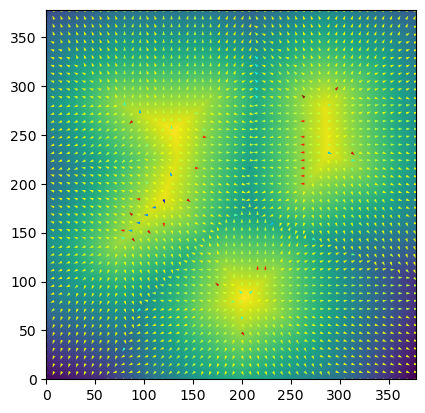

KeyboardInterrupt: 

In [1]:

import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt
import time

class WorldMoveableImageCollision:
    def __init__(self, 
                 world_image="/home/zm/MotionPolicyNetworks/storm_ws/storm/content/assets/collision_maps/collision_map_cem.png", 
                 tensor_args={'device':"cpu", 'dtype':torch.float32}):
        self.scene_im = None
        self.tensor_args = tensor_args
        im = cv2.imread(world_image, 0)
        _, im = cv2.threshold(im, 10, 255, cv2.THRESH_BINARY)
        self.im = im
        shift = 3
        self.movelist = np.float32([
            [[1, 0, -shift], [0, 1, 0]],
            [[1, 0, shift], [0, 1, 0]]])
        self.step_move = 20
        self.move_ind = 10
        plt.figure()
        self.ax = plt.subplot(1, 1, 1)
        self.ax.invert_yaxis()  # 翻转y轴

    def run(self):  
        """
        SDF  potential and gradient update
        """
        # load image and move_it
        rows, cols = self.im.shape
        ind = self.move_ind % (2 * self.step_move) // self.step_move
        self.move_ind += 1
        M_left = self.movelist[ind]
        self.im = cv2.warpAffine(self.im, M_left, (cols, rows), borderMode=cv2.BORDER_CONSTANT, borderValue=255)

        im_obstacle = cv2.bitwise_not(self.im)
        dist_obstacle = cv2.distanceTransform(im_obstacle, cv2.DIST_L2, 3)
        dist_outside = cv2.distanceTransform(self.im, cv2.DIST_L2, 3)

        dist_map = dist_obstacle - dist_outside
        self.dist_map = torch.as_tensor(dist_map, **self.tensor_args)

        # 在将2D图像转成SDF后，现在需要刻画SDF的梯度并尝试可视化梯度效果
        # 大致的运算：
        grad_y, grad_x = torch.gradient(self.dist_map)
        # 可视化 grad_x ， grad_y 应该如何设计？ 
        gradient_magnitude = torch.sqrt(grad_x**2 + grad_y**2 + 1e-10)
        # 这里的转向问题是坑，要多调试多看看 
        norm_grad_x, norm_grad_y = -grad_x / gradient_magnitude, -grad_y / gradient_magnitude
        # 定义箭头位置
        x_range, y_range = self.dist_map.shape
        x_step = y_step =  8
        x = np.arange(0, x_range, x_step)
        y = np.arange(0, y_range, y_step)
        X, Y = np.meshgrid(x, y)
        # 绘制箭头
        self.ax.cla()
        self.ax.set_xlim(0, x_range)
        self.ax.set_ylim(0, y_range)
        self.ax.imshow(self.dist_map.cpu())
        self.ax.quiver(X, Y, 
                       norm_grad_x[::x_step, ::y_step].cpu().numpy(), 
                       norm_grad_y[::x_step, ::y_step].cpu().numpy(), 
                       gradient_magnitude[::x_step, ::y_step].cpu().numpy(), 
                       cmap=plt.cm.jet)
        plt.pause(1e-10)

updatesdf = WorldMoveableImageCollision()
while True:
    updatesdf.run()


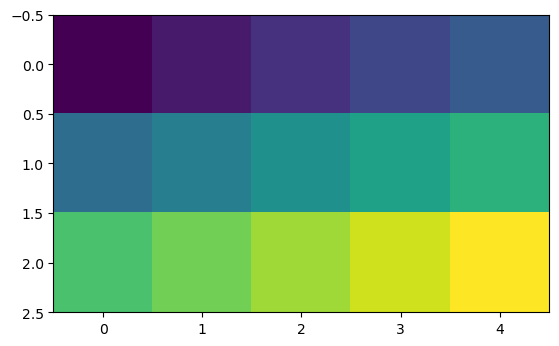

In [ ]:
import matplotlib.pyplot as plt
import torch

plt.figure()
ax = plt.subplot(1,1,1)
ax.invert_yaxis()

t = torch.arange(15).view(3,-1)
ax.imshow(t.cpu())

In [ ]:
grad_y,grad_x = torch.gradient(t)
print(grad_y,grad_x)

tensor([[5., 5., 5., 5., 5.],
        [5., 5., 5., 5., 5.],
        [5., 5., 5., 5., 5.]]) tensor([[1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.]])


In [ ]:
grad_x.shape

torch.Size([3, 5])

In [ ]:
pause = True

In [ ]:
pause =  not pause
print(pause)

True


TypeError: imshow() missing 1 required positional argument: 'X'

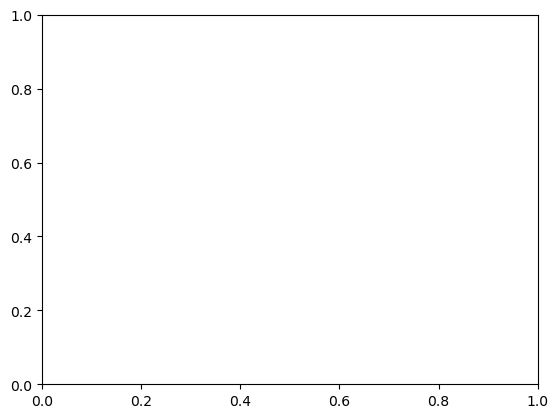

In [ ]:
import matplotlib.pyplot as plt
import time

pause = False

def key_call_back(event):
    global pause
    pause = not pause
    print(event)

fig = plt.figure()
ax = plt.subplot(1,1,1)

fig.canvas.mpl_connect('key_press_event', key_call_back)

while (True):
    plt.imshow()
    if pause:
        time.sleep(1)
        print(pause)




In [ ]:
import numpy as np
from scipy.spatial.transform import Rotation

# Define the gradient vector (replace with your actual values)
gradient = np.array([0, 0.0, 1])  # Replace with your unit vector
unitX = np.array([1.0, 0.0, 0.0])  # Assuming unitX is the x-axis

# Calculate the rotation axis and angle
angle = -np.arccos(np.dot(gradient, unitX) / (np.linalg.norm(gradient) * np.linalg.norm(unitX)))
axis = np.cross(gradient, unitX)
axis /= np.linalg.norm(axis)

# Create a rotation object
rotation = Rotation.from_rotvec(angle * axis)

# Get the quaternion
quaternion = rotation.as_quat()

# Print the quaternion components
print("Quaternion (x, y, z, w):", quaternion)


Quaternion (x, y, z, w): [-0.         -0.70710678 -0.          0.70710678]


In [ ]:
import numpy as np
from scipy.spatial.transform import Rotation

# Define the gradient vector (replace with your actual values)
gradient = np.array([0, 0.0, 1])
unitX = np.array([1.0, 0.0, 0.0])  # Assuming unitX is the x-axis

# Calculate the quaternion directly
rotation = Rotation.from_euler('z', -np.arccos(np.dot(gradient, unitX)), degrees=False)
quaternion = rotation.as_quat()

# Print the quaternion components
print("Quaternion (x, y, z, w):", quaternion)


Quaternion (x, y, z, w): [ 0.          0.         -0.70710678  0.70710678]


In [14]:
import matplotlib.pyplot as plt
import numpy as np

X, Y = np.meshgrid(np.arange(0, 2 * np.pi, .2), np.arange(0, 2 * np.pi, .2))
U = np.cos(X)
V = np.sin(Y)

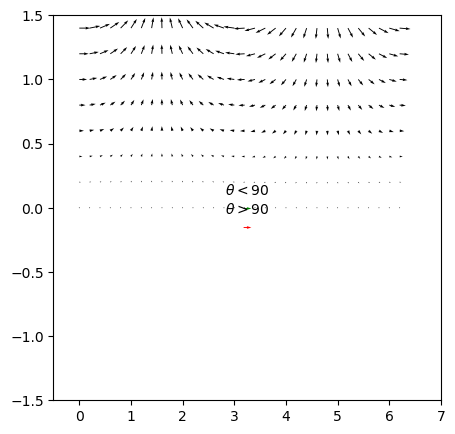

In [24]:
import matplotlib.pyplot as plt
import numpy as np

# 生成一些随机数据
x, y = np.meshgrid(np.arange(0, 2 * np.pi, .2), np.arange(0, 2 * np.pi, .2))
u, v = np.cos(x) * y, np.sin(x) * y

# 绘制箭头
fig, axs = plt.subplots(1, 1, figsize=(5, 5))
q = axs.quiver(x, y, u, v, scale=50)

# 添加标注
axs.quiverkey(q, X=0.5, Y=0.5, U=1, label=r'$\theta<90$', color='g')
axs.quiverkey(q, X=0.5, Y=0.45, U=1, label=r'$\theta>90$', color='r')

# 设置坐标轴范围
axs.set_xlim(-0.5, 7)
axs.set_ylim(-1.5, 1.5)

# 显示图形
plt.show()


(0.0, 1.0)

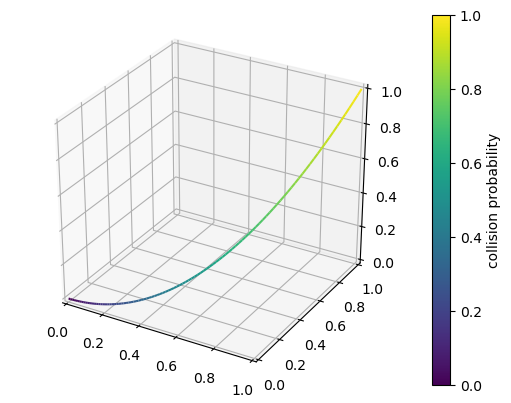

In [21]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d.art3d import Line3DCollection

# 假设 x, y, z 是你的数据
x = np.linspace(0, 1, 100)
y = x ** 2
z = x ** 3
c = x # 这里你可以使用你的 'coll' 集合


# 创建一个集合来保存线段
points = np.array([x, y, z]).T.reshape(-1, 1, 3)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

# 基于 'c' 值创建一个色彩映射
norm = plt.Normalize(c.min(), c.max())
lc = Line3DCollection(segments, cmap='viridis', norm=norm)

# 设置每一段的色彩
lc.set_array(c)
# 创建图像和3D绘图
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# 在3D绘图中添加线段集合
ax.add_collection(lc)

# 添加颜色条
cbar = plt.colorbar(lc, ax = ax)
cbar.set_label('collision probability')

# 设置3D绘图的边界
ax.set_xlim(x.min(), x.max())
ax.set_ylim(y.min(), y.max())
ax.set_zlim(z.min(), z.max())

In [22]:
norm